# Finding Giant Component

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/edges.csv')
df.head()

,# source,target
0,0,1
1,0,6
2,0,21
3,0,130
4,0,165


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6452 entries, 0 to 6451
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   # source  6452 non-null   int64
 1    target   6452 non-null   int64
dtypes: int64(2)
memory usage: 100.9 KB


In [4]:
G = nx.Graph()
G.add_edges_from(zip(df['# source'], df[' target']))

In [5]:
largest_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(largest_component)

In [6]:
# Print basic stats
print(f"Giant component size: {len(G_giant.nodes)} nodes, {len(G_giant.edges)} edges")

Giant component size: 2217 nodes, 6418 edges


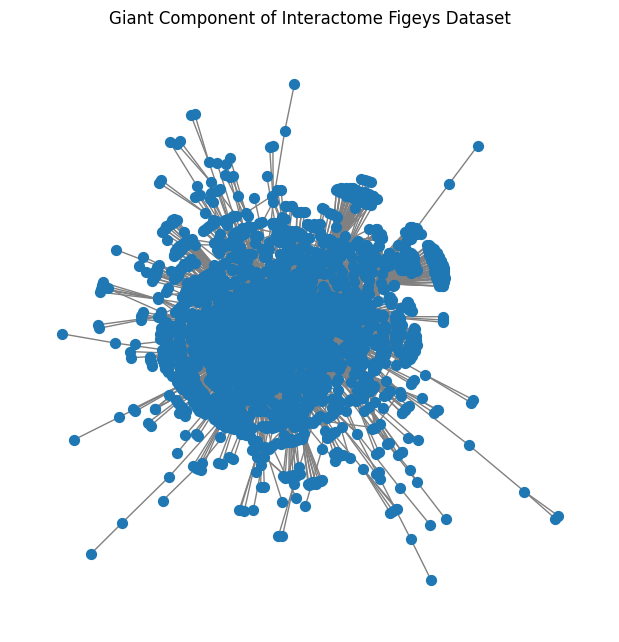

In [14]:
# Draw the graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G_giant, seed=42)  # Layout algorithm
nx.draw(G_giant, pos, node_size=50, edge_color="gray", with_labels=False)
plt.title("Giant Component of Interactome Figeys Dataset")
plt.show()


In [29]:
# Visualize the giant component

def plot_graph(G, title):
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.5)
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.title(title)
    plt.axis('off')
    plt.show()


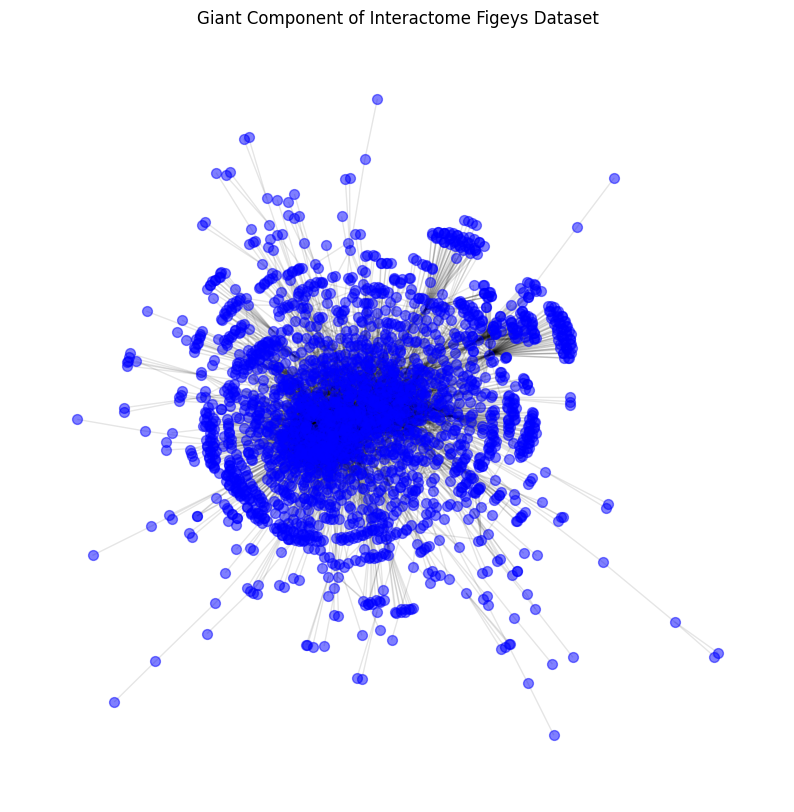

In [27]:
plot_graph(G_giant, "Giant Component of Interactome Figeys Dataset")

# Targeted Attack & Random Attack

In [22]:
import random

def random_attack(G, fraction=0.1):
    """
    Randomly remove a fraction of nodes from the graph.
    """
    num_remove = int(len(G.nodes) * fraction)
    remove_nodes = random.sample(list(G.nodes()), num_remove)
    G_removed = G.copy()
    G_removed.remove_nodes_from(remove_nodes)
    return G_removed


In [23]:
def targeted_attack(G, fraction=0.1):
    """
    Removes a fraction of high-degree nodes.
    """
    num_remove = int(len(G.nodes) * fraction)
    sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)  # Sort by degree
    remove_nodes = [node for node, _ in sorted_nodes[:num_remove]]
    G_removed = G.copy()
    G_removed.remove_nodes_from(remove_nodes)
    return G_removed


In [25]:
G_giant_attacked_random = random_attack(G_giant, fraction=0.1)
G_giant_attacked_targeted = targeted_attack(G_giant, fraction=0.1)

print(f"Random Attack: {len(G_giant_attacked_random.nodes)} nodes remain")
print(f"Targeted Attack: {len(G_giant_attacked_targeted.nodes)} nodes remain")


Random Attack: 1996 nodes remain
Targeted Attack: 1996 nodes remain


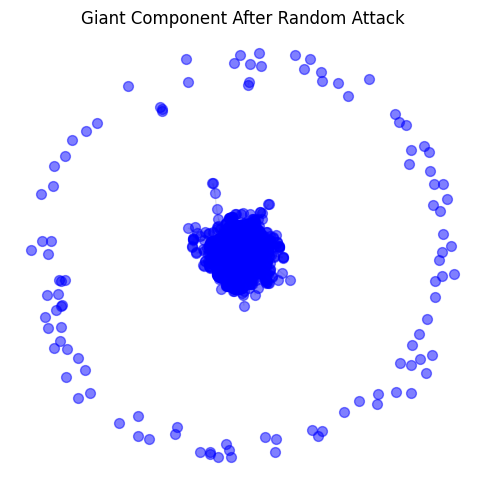

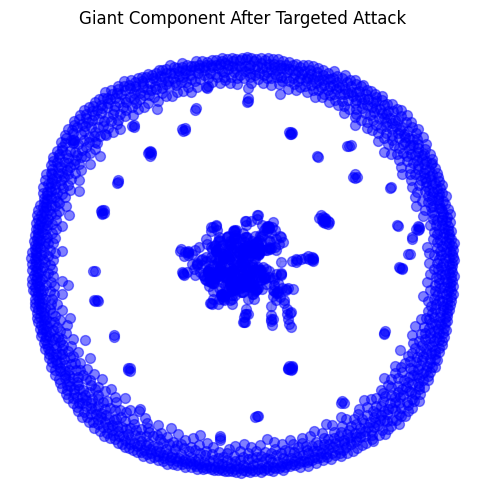

In [30]:
plot_graph(G_giant_attacked_random, "Giant Component After Random Attack")
plot_graph(G_giant_attacked_targeted, "Giant Component After Targeted Attack")

In [35]:
def get_giant_component(G):
    largest_component = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_component).copy()


In [36]:
def random_diffusion(G, steps=10):
    sizes = []
    G_copy = G.copy()
    for _ in range(steps):
        if len(G_copy.nodes) == 0:
            break
        node = random.choice(list(G_copy.nodes))
        G_copy.remove_node(node)
        giant = get_giant_component(G_copy)
        sizes.append(len(giant.nodes))
    return sizes


In [39]:
def targeted_diffusion(G, steps=10):
    sizes = []
    G_copy = G.copy()
    for _ in range(steps):
        if len(G_copy.nodes) == 0:
            break
        node = max(G_copy.degree, key=lambda x: x[1])[0]  # Highest-degree node
        G_copy.remove_node(node)
        giant = get_giant_component(G_copy)
        sizes.append(len(giant.nodes))
    return sizes


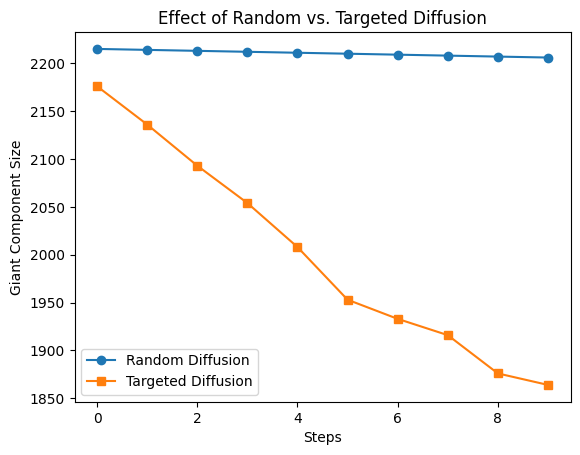

In [40]:
# Run diffusion models
random_sizes = random_diffusion(G_giant)
targeted_sizes = targeted_diffusion(G_giant)

# Step 5: Plot the results
plt.plot(range(len(random_sizes)), random_sizes, label="Random Diffusion", marker="o")
plt.plot(range(len(targeted_sizes)), targeted_sizes, label="Targeted Diffusion", marker="s")
plt.xlabel("Steps")
plt.ylabel("Giant Component Size")
plt.title("Effect of Random vs. Targeted Diffusion")
plt.legend()
plt.show()


# Implement network immunization 

In [42]:
def degree_based_protection(G, fraction=0.1):
    G_protected = G.copy()
    num_protect = int(len(G.nodes) * fraction)
    high_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:num_protect]
    
    for node, _ in high_degree_nodes:
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 1:
            G_protected.add_edge(neighbors[0], neighbors[1])  # ایجاد ارتباط بین همسایگان
    return G_protected


In [43]:
def random_protection(G, fraction=0.1):
    G_protected = G.copy()
    num_protect = int(len(G.nodes) * fraction)
    nodes = random.sample(list(G.nodes), num_protect)
    
    for node in nodes:
        potential_links = random.sample(list(G.nodes), 2)  # انتخاب دو گره برای اتصال
        G_protected.add_edge(*potential_links)
    return G_protected


In [44]:
G_giant = get_giant_component(G)
G_protected_degree = degree_based_protection(G_giant, fraction=0.1)
G_protected_random = random_protection(G_giant, fraction=0.1)


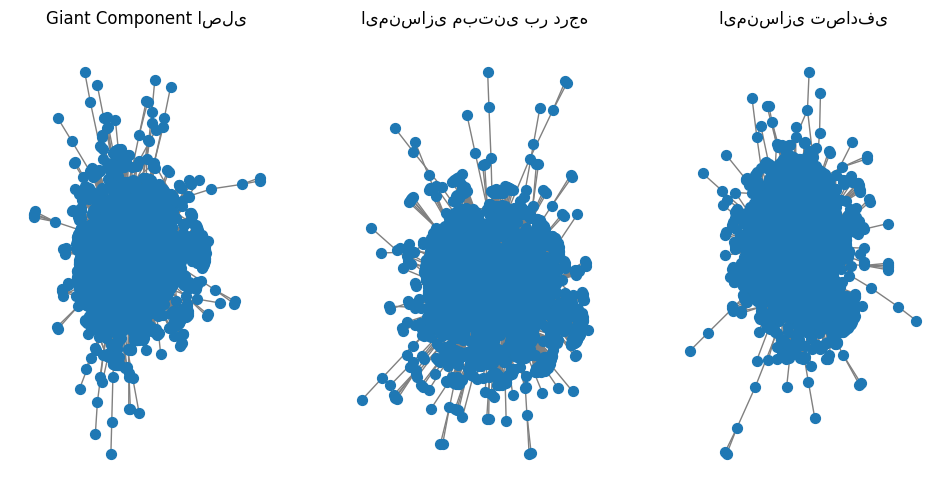

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
nx.draw(G_giant, node_size=50, edge_color="gray", with_labels=False)
plt.title("Giant Component اصلی")

plt.subplot(1, 3, 2)
nx.draw(G_protected_degree, node_size=50, edge_color="gray", with_labels=False)
plt.title("ایمن‌سازی مبتنی بر درجه")

plt.subplot(1, 3, 3)
nx.draw(G_protected_random, node_size=50, edge_color="gray", with_labels=False)
plt.title("ایمن‌سازی تصادفی")

plt.show()
